In [1]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 69.4 MB/s eta 0:00:00


In [2]:
!pip install krotov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.7 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210077 sha256=cb34a12f8d12b322c5216485bec267736ef5f4f526898f4ef1ffc6080b3549f9
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [3]:
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d


In [4]:
def hamiltonian(omega=1 , ampl0=0.2 ):
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t , args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )
    return [H0,[H1,guess_control]]


In [5]:
H = hamiltonian()
H

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[-0.5  0. ]
  [ 0.   0.5]],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 1.]
   [1. 0.]],
  <function __main__.hamiltonian.<locals>.guess_control(t, args)>]]

In [6]:
tlist = np.linspace(0, 5, 500)

In [7]:
def logical_basis(H):
    H0 = H[0]
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi0, psi1

psi0, psi1 = logical_basis(H)

Energy of qubit transition is 1.000


In [8]:
proj0 = qutip.ket2dm(psi0)
proj1 = qutip.ket2dm(psi1)

In [9]:
objectives = krotov.gate_objectives(
    basis_states=[psi0, psi1], gate=qutip.operators.sigmax(), H=H
)

objectives

[Objective[|Ψ₀(2)⟩ to |Ψ₁(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)]]],
 Objective[|Ψ₁(2)⟩ to |Ψ₀(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)]]]]

In [10]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

pulse_options = {H[1][1]: dict(lambda_a=1, update_shape=S)}

In [11]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_sm,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_sm),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.51e-01    0.00e+00   9.51e-01        n/a        n/a     2
1     7.72e-01    5.46e-02   8.26e-01  -1.80e-01  -1.25e-01     4
2     3.15e-01    1.61e-01   4.75e-01  -4.57e-01  -2.97e-01     4
3     5.13e-02    1.15e-01   1.66e-01  -2.63e-01  -1.48e-01     4
4     1.41e-02    1.76e-02   3.17e-02  -3.71e-02  -1.96e-02     3
5     6.17e-03    3.94e-03   1.01e-02  -7.98e-03  -4.04e-03     4
6     2.51e-03    1.83e-03   4.33e-03  -3.66e-03  -1.83e-03     4
7     9.10e-04    7.96e-04   1.71e-03  -1.60e-03  -8.00e-04     4


In [12]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2023-08-01 08:08:29
- Number of objectives: 2
- Number of iterations: 7
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2023-08-01 08:09:00 (0:00:31)

In [13]:
def plot_pulse(pulse, tlist, xlimit=None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('pulse amplitude')
    if xlimit is not None:
        ax.set_xlim(xlimit)
    plt.show(fig)

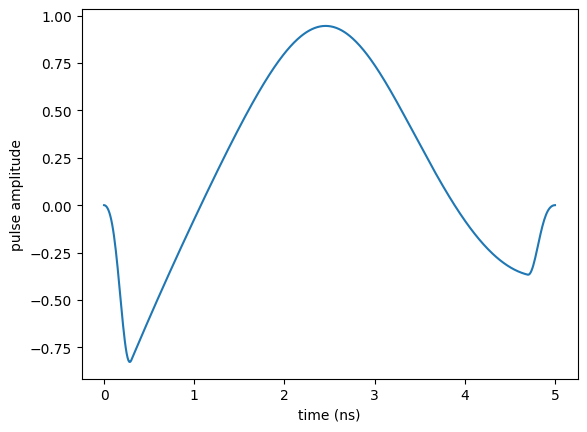

In [14]:
plot_pulse(opt_result.optimized_controls[0], tlist)

In [15]:
opt_dynamics1 = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

opt_dynamics2 = opt_result.optimized_objectives[1].mesolve(
    tlist, e_ops=[proj0, proj1])

In [18]:
def plot_population(result):
    '''Representation of the expected values for the initial states'''
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')

    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

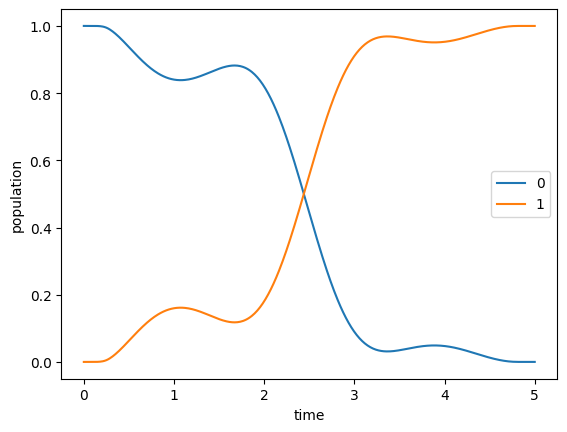

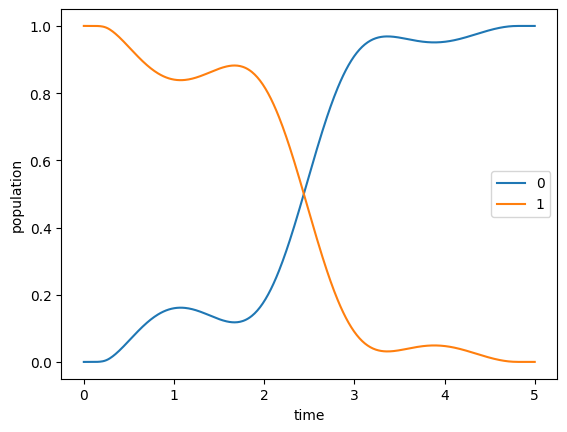

In [19]:
plot_population(opt_dynamics1)
plot_population(opt_dynamics2)